# Artificial Neural Network
### Artificial Neural Network (ANN) is a supervised learning algorithm that mimics the human brain by processing data through interconnected layers of neurons, learning complex patterns to predict outcomes. It excels in classifying wine quality categories (e.g., predicting quality levels based on physicochemical properties like alcohol and total acidity) and can handle both classification and regression tasks, requiring extensive training to adjust weights and biases. The algorithm assumes that the data can be modeled with non-linear transformations across layers, which enables flexibility but may not hold for datasets with insufficient samples or poor feature representation. Its strength lies in its ability to capture intricate relationships in high-dimensional data, but it can be computationally intensive, prone to overfitting without regularization, and sensitive to hyperparameter choices (e.g., layer size, learning rate).

### Use ANN for your supervised learning prototypes, with tuning of architecture and regularization to optimize performance, particularly for deployment in predictive analytics or deep learning systems.

| Aspect | Details |
| :- | :- |
| Use For           | Classification (e.g., wine quality prediction, image recognition)<br>Can be extended to regression with appropriate output layers |
| Key Assumptions   | - Data can be modeled with non-linear transformations<br>- Independent observations<br>- Sufficient data for weight optimization |
| Advantages        | - Captures complex, non-linear patterns<br>- Highly flexible with layered architecture<br>- Effective for high-dimensional data |
| Disadvantages     | - Computationally intensive during training<br>- Prone to overfitting without regularization<br>- Sensitive to hyperparameter tuning |
| Avoid When        | - Very small datasets with limited samples<br>- Need for highly interpretable models<br>- Real-time applications with low latency |
| Real-World Use Case | Wine quality prediction (e.g., classifying quality based on chemical properties)<br>Image recognition (e.g., identifying objects in photographs) |

## Problem Description: 
### Predict the quality of red wine (rated from 3 to 8) based on physicochemical properties like alcohol content, pH, and volatile acidity. This is a multi-class classification problem where ANNs can learn complex, non-linear patterns through layered neurons.

Using dataset https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

2025-06-13 19:23:00.943329: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 19:23:01.052129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749838981.126309 1403842 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749838981.147752 1403842 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749838981.242925 1403842 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def setup_gpu():
    ## tf version
    print("TensorFlow version:", tf.__version__)

    #### GPU Optimisation code ####
    print("GPUs:",tf.config.list_physical_devices('GPU'))

    print("GPUs: Allocate GPU Memory and create a new session")

    # Get the GPU memory fraction to allocate
    gpu_memory_fraction = 0.5

    # Create GPUOptions with the fraction of GPU memory to allocate
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)

    # Create a session with the GPUOptions
    session = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
setup_gpu()

TensorFlow version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: Allocate GPU Memory and create a new session


I0000 00:00:1749838984.241038 1403842 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5119 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
project_dir = './13_ann_articifical_neural_network'

# load  dataset
data = pd.read_csv(project_dir + '/data/winequality-red.csv')
print("Dataset loaded, shape:", data.shape)

# feature engineering
data['total_acidity'] = data['fixed acidity'] + data['volatile acidity'] + data['citric acid']

# select relevant features
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 
            'total_acidity']

X = data[features]
y = data['quality'] - 3  # 0-5 for categorical encoding
print("Features shape:", X.shape, "Target shape:", y.shape)


# scale features for better ANN performance
scaler = StandardScaler()
X = scaler.fit_transform(X)

# convert target to one-hot encoding for multi-class classification
y = to_categorical(y, num_classes=6)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set shape:", X_train.shape, "Test set shape:", X_test.shape)

Dataset loaded, shape: (1599, 12)
Features shape: (1599, 12) Target shape: (1599,)
Train set shape: (1279, 12) Test set shape: (320, 12)


In [5]:
# build the ANN model
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(len(features),)),
    Dropout(0.1),  # Add dropout to prevent overfitting
    Dense(64, activation='relu'),
    Dropout(0.1),  
    Dense(32, activation='relu'),
    Dropout(0.1), 
    Dense(6, activation='softmax')  
])


# compile the model
custom_optimizer = Adam(learning_rate=0.0001) # reduced initial learning rate
ann_model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=0.1)

# train the ANN model
history = ann_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)

/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749838984.270761 1403842 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5119 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/50


I0000 00:00:1749838985.471739 1403986 service.cc:152] XLA service 0x7f65cc00a810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749838985.471781 1403986 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-06-13 19:23:05.492218: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749838985.598656 1403986 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.0312 - loss: 1.9619

I0000 00:00:1749838986.863456 1403986 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.0282 - loss: 1.9487

2025-06-13 19:23:08.662608: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_61', 12 bytes spill stores, 12 bytes spill loads

2025-06-13 19:23:08.816285: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_61', 8 bytes spill stores, 8 bytes spill loads

2025-06-13 19:23:09.004141: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_61', 112 bytes spill stores, 112 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0288 - loss: 1.9471 - val_accuracy: 0.0469 - val_loss: 1.8812 - learning_rate: 1.0000e-04
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0554 - loss: 1.9080 - val_accuracy: 0.0625 - val_loss: 1.8481 - learning_rate: 1.0000e-04
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0671 - loss: 1.8683 - val_accuracy: 0.1172 - val_loss: 1.8169 - learning_rate: 1.0000e-04
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1016 - loss: 1.8323 - val_accuracy: 0.1719 - val_loss: 1.7872 - learning_rate: 1.0000e-04
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1188 - loss: 1.8190 - val_accuracy: 0.2383 - val_loss: 1.7595 - learning_rate: 1.0000e-04
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1701 - loss: 1.7863 - val_accuracy: 0.3008 - val_loss: 1.7330 - learning_rate: 1.0000e-04
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1931 - loss: 1.7680 - val_accuracy:

In [6]:
# predict and evaluate
y_pred = ann_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) + 3  # 3-8
y_test_classes = np.argmax(y_test, axis=1) + 3
accuracy = accuracy_score(y_test_classes, y_pred_classes)
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
class_report = classification_report(y_test_classes, y_pred_classes, output_dict=True)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_report(y_test_classes, y_pred_classes))

2025-06-13 19:23:13.838347: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18', 4 bytes spill stores, 4 bytes spill loads

2025-06-13 19:23:13.908876: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18', 12 bytes spill stores, 12 bytes spill loads



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  
Accuracy: 0.57
Confusion Matrix:
[[  0   0   1   0   0   0]
 [  0   0   9   1   0   0]
 [  0   0 102  28   0   0]
 [  0   0  53  70   9   0]
 [  0   0   3  30   9   0]
 [  0   0   0   3   2   0]]
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.61      0.78      0.68       130
           6       0.53      0.53      0.53       132
           7       0.45      0.21      0.29        42
           8       0.00      0.00      0.00         5

    accuracy                           0.57       320
   macro avg       0.26      0.25      0.25       320
weighted avg       0.52      0.57      0.53       320



/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

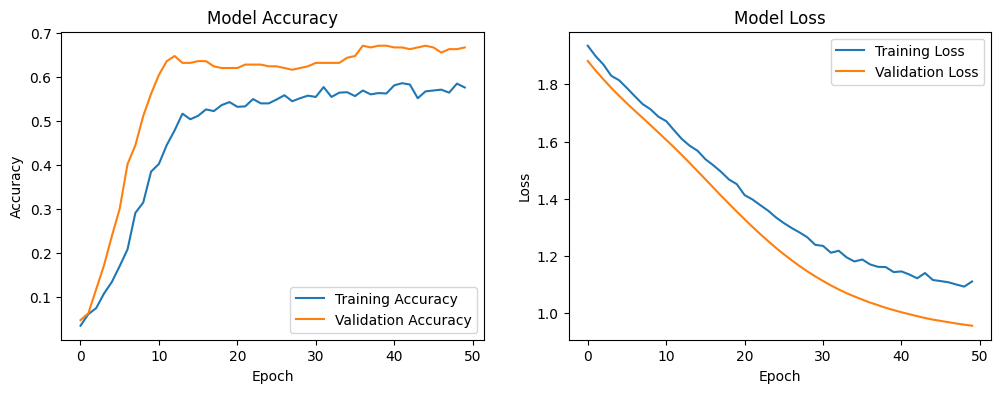

In [7]:
# visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# save the model and scaler in a 'model' subdirectory
model_dir = project_dir + '/model' 
os.makedirs(model_dir, exist_ok=True)
model_filename = os.path.join(model_dir, 'wine_quality_ann_model.h5')
scaler_filename = os.path.join(model_dir, 'wine_quality_scaler.pkl')
ann_model.save(model_filename)
joblib.dump(scaler, scaler_filename)
print(f'Model saved as {model_filename}')
print(f'Scaler saved as {scaler_filename}')

Model saved as ./13_ann_articifical_neural_network/model/wine_quality_ann_model.h5
Scaler saved as ./13_ann_articifical_neural_network/model/wine_quality_scaler.pkl


In [9]:
# load the PCA model and scaler, and run a transformation test
loaded_model = tf.keras.models.load_model(model_filename)
loaded_scaler = joblib.load(scaler_filename)
sample_data = pd.DataFrame(
    [[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4, 8.1]],
    columns=features
)
sample_input_scaled = loaded_scaler.transform(sample_data)
sample_prediction = loaded_model.predict(sample_input_scaled)
sample_prediction_class = np.argmax(sample_prediction, axis=1) + 3
print(f'Predicted Wine Quality for sample input: {sample_prediction_class[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Predicted Wine Quality for sample input: 5
